<a href="https://colab.research.google.com/github/KurniaKhaikal/BreastCancerIDC-CNN/blob/khaikal/New_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import neccessary Libraries and modules
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"khaikal","key":"9e492a7553b8e713debda6f4f6810151"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:50<00:00, 29.1MB/s]
100% 3.10G/3.10G [00:50<00:00, 65.5MB/s]


In [4]:
import os
import zipfile

local_zip = '/content/breast-histopathology-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/input')
zip_ref.close()

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [6]:
imagePatches = glob('/content/input/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x1301_y1901_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x1101_y1601_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x1301_y2201_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x1151_y1901_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x1351_y2001_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x2551_y851_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x2701_y1101_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x901_y1801_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x1301_y1551_class1.png
/content/input/IDC_regular_ps50_idx5/9259/1/9259_idx5_x1251_y2201_class1.png


In [7]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [8]:
len(class1)

78786

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
sampled_class0 = random.sample(class0, 78786)
sampled_class1 = random.sample(class1, 78786)

In [11]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [12]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [13]:
class0_array[1]

[array([[[199, 165, 214],
         [169, 121, 167],
         [153, 102, 165],
         ...,
         [151,  95, 170],
         [187, 150, 204],
         [194, 155, 208]],
 
        [[146,  90, 155],
         [159, 109, 164],
         [151,  91, 158],
         ...,
         [158, 115, 195],
         [187, 150, 208],
         [184, 146, 203]],
 
        [[135,  77, 138],
         [140,  84, 147],
         [137,  76, 132],
         ...,
         [159, 107, 166],
         [181, 136, 190],
         [156, 113, 158]],
 
        ...,
 
        [[173, 130, 209],
         [174, 133, 210],
         [176, 133, 209],
         ...,
         [190, 158, 198],
         [194, 157, 208],
         [185, 146, 209]],
 
        [[188, 151, 209],
         [197, 161, 215],
         [188, 152, 214],
         ...,
         [175, 131, 190],
         [199, 165, 205],
         [182, 138, 209]],
 
        [[178, 135, 205],
         [199, 169, 212],
         [195, 160, 209],
         ...,
         [185, 150, 208],
  

In [14]:
test = cv2.imread('/content/input/IDC_regular_ps50_idx5/10253/1/10253_idx5_x501_y351_class1.png' ,cv2.IMREAD_COLOR)
test.shape

(50, 50, 3)

In [15]:
from keras.preprocessing.image import load_img, img_to_array

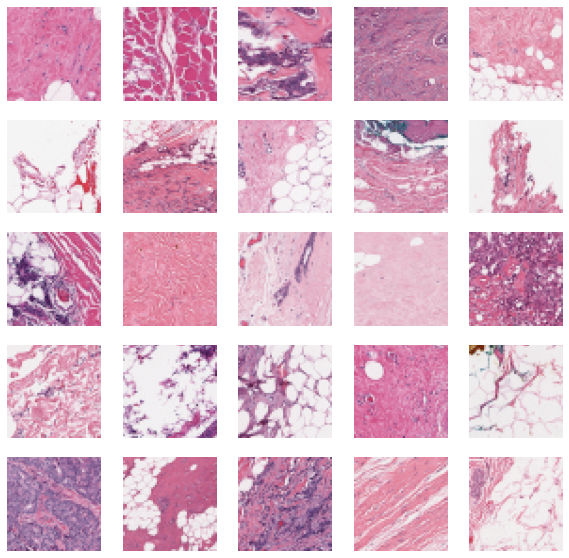

In [16]:
def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 25)
    i=0
    for loc in ind:
        plt.subplot(5,5,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

show_img(imagePatches)

In [17]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(combined_data)

In [18]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [19]:
X = np.array(X).reshape(-1, 50, 50, 3)

In [20]:
X.shape

(157572, 50, 50, 3)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(126057, 50, 50, 3) (31515, 50, 50, 3) (126057, 2) (31515, 2)


In [22]:
def create_model():        
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(50,50,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    #binary_crossentropy is used as Cancer detecion is  binary classification model
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   

    return model

In [23]:
with strategy.scope():
    model = create_model()
#Training and Testing the CNN 
#epochs determines no of times learning algorithm walks through the dataset
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 20,
    verbose = 2,
)


Epoch 1/20
3940/3940 - 1205s - loss: 0.3989 - accuracy: 0.8655 - val_loss: 0.3366 - val_accuracy: 0.8565 - 1205s/epoch - 306ms/step
Epoch 2/20
3940/3940 - 1203s - loss: 0.3025 - accuracy: 0.8820 - val_loss: 0.2903 - val_accuracy: 0.8850 - 1203s/epoch - 305ms/step
Epoch 3/20
3940/3940 - 1212s - loss: 0.2593 - accuracy: 0.9018 - val_loss: 0.2949 - val_accuracy: 0.8939 - 1212s/epoch - 308ms/step
Epoch 4/20
3940/3940 - 1213s - loss: 0.2258 - accuracy: 0.9170 - val_loss: 0.2924 - val_accuracy: 0.8912 - 1213s/epoch - 308ms/step
Epoch 5/20
3940/3940 - 1212s - loss: 0.1899 - accuracy: 0.9310 - val_loss: 0.2897 - val_accuracy: 0.9075 - 1212s/epoch - 308ms/step
Epoch 6/20
3940/3940 - 1210s - loss: 0.1625 - accuracy: 0.9421 - val_loss: 0.3242 - val_accuracy: 0.9089 - 1210s/epoch - 307ms/step
Epoch 7/20
3940/3940 - 1221s - loss: 0.1388 - accuracy: 0.9518 - val_loss: 0.3057 - val_accuracy: 0.9130 - 1221s/epoch - 310ms/step
Epoch 8/20
3940/3940 - 1212s - loss: 0.1176 - accuracy: 0.9596 - val_loss: 0

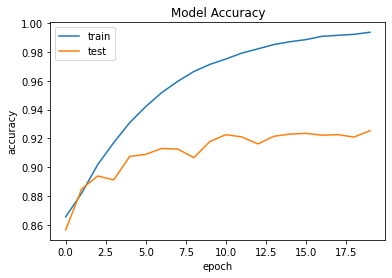

In [24]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

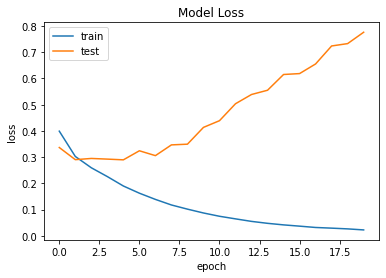

In [25]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
y_pred=model.predict(X_test)

In [28]:
y_pred[21]

array([1.0000000e+00, 1.2580829e-12], dtype=float32)

In [29]:
y_test[21]

array([1., 0.], dtype=float32)

In [30]:
Y_pred=[]
for i in y_pred:
    if i[0]>i[1]:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [31]:
Y_test=[]
for i in y_test:
    if i[0]>i[1]:
        Y_test.append(0)
    else:
        Y_test.append(1)

In [32]:
Y_pred[0]

0

In [33]:
Y_test[0]

0

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test, Y_pred))
print('Classification Report')
print(classification_report(Y_test, Y_pred, target_names=['Negative','Positive']))

Confusion Matrix
[[25783   887]
 [ 1466  3379]]
Classification Report
              precision    recall  f1-score   support

    Negative       0.95      0.97      0.96     26670
    Positive       0.79      0.70      0.74      4845

    accuracy                           0.93     31515
   macro avg       0.87      0.83      0.85     31515
weighted avg       0.92      0.93      0.92     31515



In [35]:
model.save('/content/input/modelcnn.h5')

In [36]:
confusionmatrix=confusion_matrix(Y_test, Y_pred)

In [37]:
confusionmatrix.shape

(2, 2)

In [38]:
classes=[0,1]
con_mat_df = pd.DataFrame(confusion_matrix(Y_test, Y_pred),
                     index = classes, 
                     columns = classes)

con_mat_df

,0,1
0,25783,887
1,1466,3379


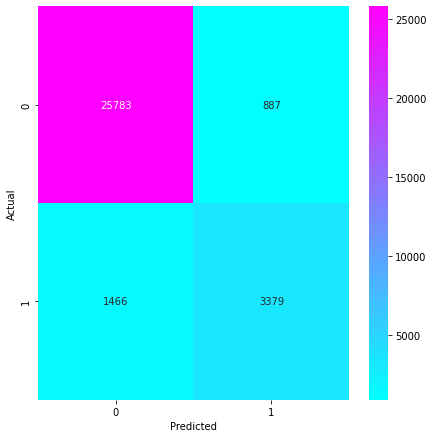

In [39]:
import seaborn as sns

figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()